# Anomaly detection on ping measurements
The goal for this Jupyter Notebook is to gain a better understanding off how the Ping measurement data looks and in what way we can detect anomalies in the data.

The data selected is from an anchoring measurement towards an anchor located in San Fransisco, around the time of an internet outage from Fastly [1].
According to the article the outage should be around 11:00 UTC on june 8th. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from measurement_import import PingImport
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from luminol.anomaly_detector import AnomalyDetector

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload

## Data import

Because opening the JSON takes very long, this is the dataset with all irrelevant columns removed.

In [6]:
ping_import = PingImport()
df_ping = ping_import.read_dataset('measurement_data/ping-measurement_1.json')
df_ping

,index,created,probe_id,duplicates,rtt_average,rtt_max,rtt_min,rtt_median,dropped_packets
0,0,2021-06-07 00:02:11+00:00,6025,0,149.218,149.233853,149.195256,149.225,0
1,1,2021-06-07 00:02:21+00:00,6030,0,166.576,166.850203,166.409528,166.467,0
2,2,2021-06-07 00:02:22+00:00,6031,0,149.319,149.741417,149.048305,149.168,0
3,3,2021-06-07 00:02:21+00:00,6039,0,170.098,170.111447,170.077631,170.105,0
4,4,2021-06-07 00:02:17+00:00,6041,0,173.648,173.714002,173.588153,173.642,0
...,...,...,...,...,...,...,...,...,...
637530,678089,2021-06-09 23:58:21+00:00,7006,0,147.874,147.964410,147.811359,147.845,0
637531,678090,2021-06-09 23:58:17+00:00,7007,0,208.156,208.185379,208.128699,208.153,0
637532,678091,2021-06-09 23:58:09+00:00,7008,0,162.362,162.421941,162.276314,162.388,0
637533,678092,2021-06-09 23:58:08+00:00,7009,0,219.927,219.953030,219.913387,219.915,0


# Adding extra columns
To be able to more easily compare results between probes, the min round trip time median is taken as zero. The min round trip time is taken since this measurement is less sensative towards outliers (and so will be less likely to result in False Positive anomalies)

In [7]:
# Add row with difference to median for rtt_min
median_dict = {}
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    median_dict[i] = single_probe["rtt_min"].median()

def find_difference(probe_id, rtt_average):
    return rtt_average - median_dict[probe_id]

df["rtt_min_diff"] = np.vectorize(find_difference)(df['probe_id'], df['rtt_min'])

In [8]:
# Add row with difference to median for rtt_average
median_dict = {}
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    median_dict[i] = single_probe["rtt_average"].median()

def find_difference(probe_id, rtt_average):
    return rtt_average - median_dict[probe_id]

df["rtt_average_diff"] = np.vectorize(find_difference)(df['probe_id'], df['rtt_average'])

In [9]:
# Add row with median rtt per probe 
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    median = single_probe["rtt_min"].median()
    df.loc[df['probe_id'] == i, 'probe_rtt_median'] = median


# Multivariate graph
All probes min round trip times are visualised in a multivariate graph inspired by a paper on anomaly detection [2]. The x-axis represesents when the measurement was taken, the y-axis represent different probes sorted on the median round trip time for the period (this means that closer probes will be on the bottom of the graph, and further probes will be higher on the graph). The darker the dot at a certain time, the longer the round trip time at said time is.

In [10]:
def normalize(min_score, max_score, score):
    if max_score-min_score == 0:
        return 0
    return (score-min_score)/(max_score-min_score)

<AxesSubplot:xlabel='created', ylabel='probe_rtt_median'>

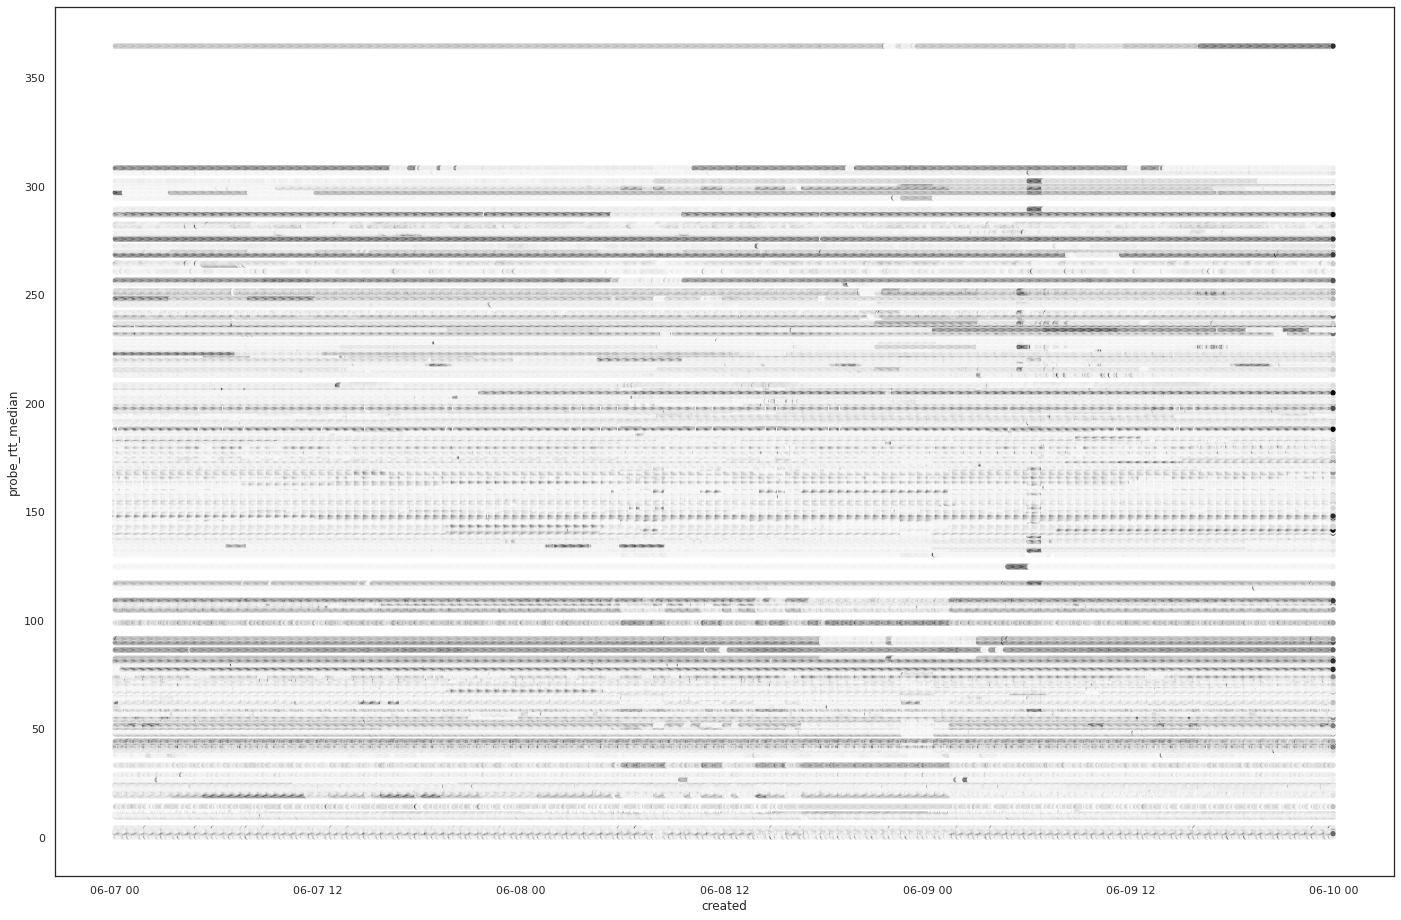

In [11]:
for probe_id in df['probe_id'].unique():
    single_probe = df[df["probe_id"] == probe_id]

    score_min = single_probe["rtt_min_diff"].min()
    score_max = single_probe["rtt_min_diff"].max()
    normalized_scores = single_probe["rtt_min_diff"].apply(lambda score: normalize(score_min, score_max, score))

    df.loc[df['probe_id'] == probe_id, 'rtt_normalized'] = normalized_scores

sns.set(rc={"figure.figsize":(24, 16)})
sns.set_style("white")
sns.scatterplot(data=df, x="created", y="probe_rtt_median", hue="rtt_normalized",legend=False, palette="light:black")

There are some spots where across multiple probes the round trip times seem to have increased (9th of june around 6:00), but this does not at first sight seems to correspond to the expexted time.

## Per probe anomaly detection and visualisation
It is possible to change the random value to see the graph for a random different probe, (or uncomment to pick specific probes). Detected anomalys are marked with red dots. For anomaly detecion the fast and easy isolation forest is used. This can later be compared to other algorithms, but in the sake off working agile has to serve right now.
A problem with isolation forest is the fact that upfront the expected percentage of anomalies has to be specified. This can be different for each probe and is not known.

Probe ID: 6041
Median RTT: 173.8195575 Average RTT: 175.12391131481485
Amount of data points: 1080


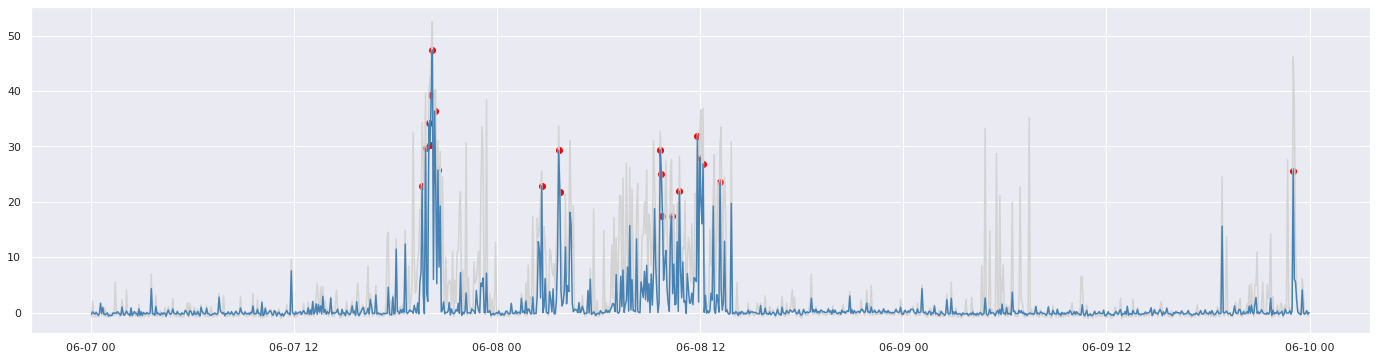

In [23]:
random_probe = df["probe_id"].sample(n=1, random_state=91).unique()[0]
# random_probe = 6229
print(f"Probe ID: {random_probe}")
single_probe1 = df[df["probe_id"] == random_probe]
single_probe1_median = single_probe1["rtt_min"].median()
single_probe1_mean = single_probe1["rtt_min"].mean()

print(f"Median RTT: {single_probe1_median} Average RTT: {single_probe1_mean}")

single_probe1_datapoints = len(single_probe1)
print(f"Amount of data points: {single_probe1_datapoints}")

# Outlier detection
clf = IsolationForest(contamination=0.02)
single_probe1["outlier"] = clf.fit_predict(single_probe1[["rtt_min", "duplicates", "dropped_packets"]])

# # Anomaly detection
# algo_settings = {
#       'precision':4, # how many sections to categorize values
#       'lag_window_size':2, # lagging window size
#       'future_window_size':2, # future window size,
#       'chunk_size':4 # chunk size.
#     }

# ts = single_probe1["rtt_min"].to_dict()
# detector = AnomalyDetector(ts, algorithm_name="bitmap_detector", algorithm_params=algo_settings)
# anomalies = detector.get_anomalies()

fig, ax = plt.subplots(figsize=(24,6))

# for anomaly in anomalies:
#     start = single_probe1.at[anomaly.start_timestamp, "created"]
#     end = single_probe1.at[anomaly.end_timestamp, "created"]
#     score = anomaly.anomaly_score
#     ax.axvspan(xmin=start, xmax=end, color="red")

a = single_probe1.loc[single_probe1['outlier'] == -1, ['created', 'rtt_min_diff']]
ax.plot(single_probe1['created'], single_probe1['rtt_average_diff'], color='lightgrey')
ax.plot(single_probe1['created'], single_probe1['rtt_min_diff'], color='steelblue')
# 
ax.scatter(a["created"], a["rtt_min_diff"], color="red")
plt.show()

<AxesSubplot:xlabel='rtt_min_diff', ylabel='Count'>

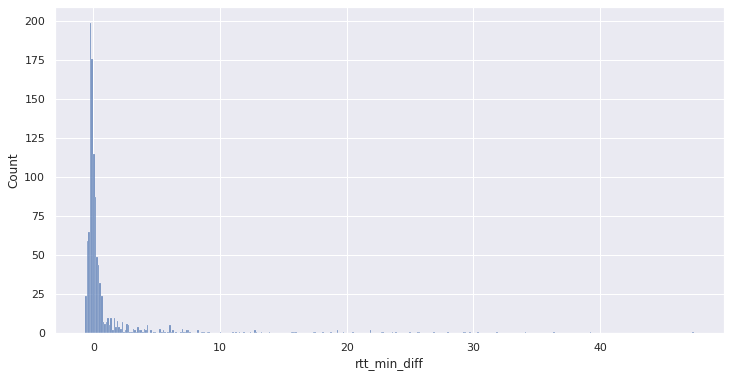

In [24]:
# check distribution
sns.set(rc={"figure.figsize":(12, 6)})
sns.histplot(data=single_probe1, x="rtt_min_diff")

## Apply outlier detection to all probes and datapoints.

In [14]:
# Find outliers in total dataset
clf = IsolationForest(contamination=0.02)
df_outlier = pd.DataFrame()
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    
    single_probe["outlier"] = clf.fit_predict(single_probe[["rtt_min", "duplicates", "dropped_packets"]])
    single_probe["outlier_score"] = clf.score_samples(single_probe[["rtt_min", "duplicates", "dropped_packets"]])
    single_probe["outlier"] = single_probe["outlier"].apply(lambda x: 0 if x == 1 else 1)
    df_outlier = df_outlier.append(single_probe)

df_outlier

,index,created,probe_id,duplicates,rtt_average,rtt_max,rtt_min,rtt_median,dropped_packets,rtt_min_diff,rtt_average_diff,probe_rtt_median,rtt_normalized,outlier,outlier_score
0,0,2021-06-07 00:02:11+00:00,6025,0,149.218,149.233853,149.195256,149.225,0,-0.043513,-0.132,149.238769,0.078451,0,-0.385571
587,623,2021-06-07 00:06:18+00:00,6025,0,149.493,149.498309,149.487248,149.493,0,0.248479,0.143,149.238769,0.171471,0,-0.466349
1173,1246,2021-06-07 00:10:17+00:00,6025,0,149.315,149.341522,149.265693,149.337,0,0.026924,-0.035,149.238769,0.100891,0,-0.397464
1758,1868,2021-06-07 00:14:20+00:00,6025,0,149.209,149.391889,149.037659,149.199,0,-0.201110,-0.141,149.238769,0.028246,0,-0.521041
2346,2492,2021-06-07 00:18:18+00:00,6025,0,149.551,150.059528,149.242088,149.352,0,0.003319,0.201,149.238769,0.093371,0,-0.393242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635162,675573,2021-06-09 23:42:14+00:00,7010,0,179.879,179.885990,179.872332,179.878,0,-0.026884,-0.045,179.899216,0.152949,0,-0.460023
635755,676203,2021-06-09 23:46:22+00:00,7010,0,179.884,179.903939,179.866280,179.880,0,-0.032936,-0.040,179.899216,0.121413,0,-0.454834
636348,676833,2021-06-09 23:50:16+00:00,7010,0,179.969,180.029638,179.929781,179.949,0,0.030565,0.045,179.899216,0.452308,0,-0.460654
636941,677463,2021-06-09 23:54:20+00:00,7010,0,179.921,179.961030,179.863718,179.939,0,-0.035498,-0.003,179.899216,0.108063,0,-0.507363


## Test if results are better when giving a higher weight to closer probes

The chosen weights are arbitrary, at first the inverse square law was used, but this resulted in to extreme an advantage for nearby probes.

In [15]:
# Give higher weights to probes with lower median RTT (closer probes)
def get_weight(median_rtt):
    if median_rtt <= 10:
        return 1
    elif 10 < median_rtt <= 30:
        return .8
    elif 30 < median_rtt <= 100:
        return .6
    elif 100 < median_rtt <= 300:
        return .2
    elif 300 < median_rtt:
        return .1

df_outlier["weight"] = df_outlier["probe_rtt_median"].apply(lambda x: get_weight(x))

In [16]:
df_outlier["outlier_weighted"] = df_outlier["outlier"] * df_outlier["weight"]
df_outlier["outlier_score_weighted"] = df_outlier["outlier_score"] * df_outlier["weight"]

## Plot sum of total amount of anomalies for each time entry

<AxesSubplot:xlabel='created'>

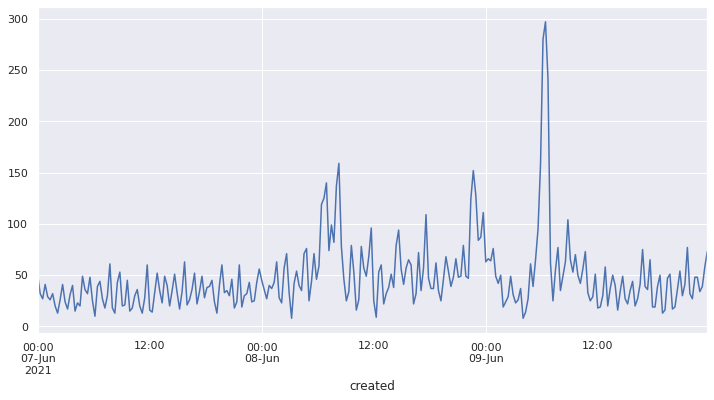

In [17]:
# Create anomaly score frame
frequency = "16T"
df_outlier.groupby(pd.Grouper(key="created", freq=frequency))["outlier"].agg("sum").plot()

## Plot Weight adjusted sum of total amount of anomalies for each time entry

<AxesSubplot:xlabel='created'>

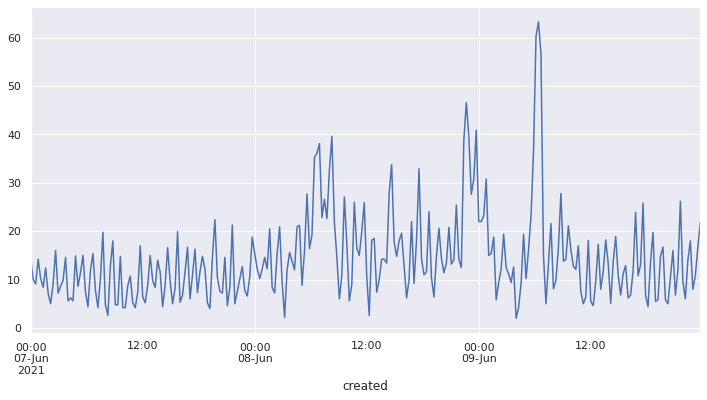

In [18]:
df_outlier.groupby(pd.Grouper(key="created", freq=frequency))["outlier_weighted"].agg("sum").plot()

## plot summed anomaly score for each time entry
Note that a lower negative score means a higher anomaly likelyhood

<AxesSubplot:xlabel='created'>

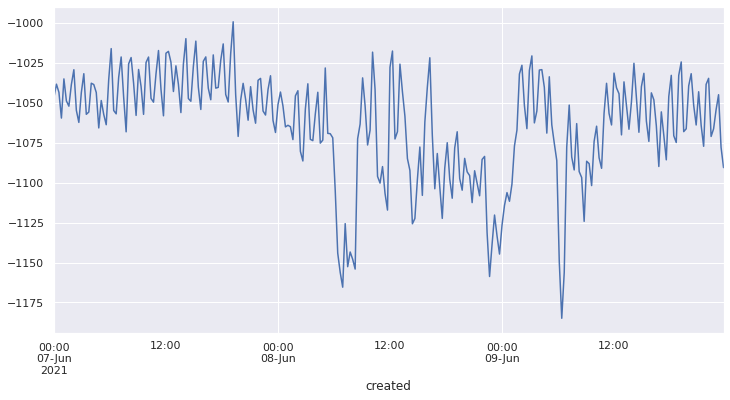

In [19]:
df_outlier.groupby(pd.Grouper(key="created", freq=frequency))["outlier_score"].agg("sum").plot()

## plot summed weighted anomaly score for each time entry
Note that a lower negative score means a higher anomaly likelyhood

<AxesSubplot:xlabel='created'>

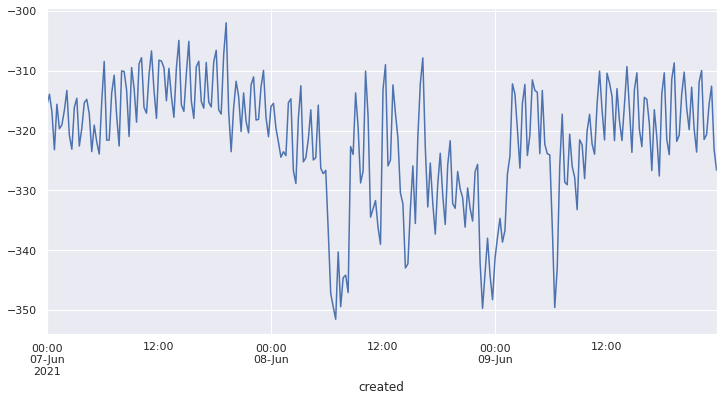

In [20]:
df_outlier.groupby(pd.Grouper(key="created", freq=frequency))["outlier_score_weighted"].agg("sum").plot()

The plots do show some moments where the complete measurement seems to be experiencing a higher state of anomaly. The first time this happend appears to be from around 6:00 on the 8th (this is slightly earlier than the expected time). There seem to be higher scores again later slightly before 00:00 on the 9th, and a short peak around 6:00 on the 9th. Right now it is hard to verify if these peaks correlate with an actual problem. 

## References
[1] “Internet Fastly Outage: Multiple Major Websites Went Offline : NPR.” https://www.npr.org/2021/06/08/1004305569/internet-fastly-outage-go-down-twitter-reddit?t=1636636476400 (accessed Dec. 02, 2021).
[2] P. Dilini Talagala, R. J. Hyndman, K. Smith-Miles, S. Kandanaarachchi, and M. A. Munoz, “Anomaly Detection in Streaming Nonstationary Temporal Data Anomaly Detection in Streaming Nonstationary Temporal Data Anomaly Detection in Streaming Nonstationary Temporal Data,” 2018, Accessed: Nov. 04, 2021. [Online]. Available: http://business.monash.edu/econometrics-and-business-statistics/research/publications.